In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm, trange
from sklearn.metrics import confusion_matrix
from scipy.stats import poisson, norm
from copy import deepcopy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.decomposition import PCA
import sys
import pickle
import blip_analysis as ba
import exp_blip_models as em
from scipy.cluster.hierarchy import dendrogram, linkage
import daskify
import dask
from scipy.stats import skewnorm, mannwhitneyu
import scipy
import matplotlib
from sklearn.manifold import LocallyLinearEmbedding, MDS
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from scipy.spatial import distance_matrix
import openephys as oe
from scipy.stats import ttest_ind
import importlib
importlib.reload(em)
importlib.reload(ba)

a
a


<module 'blip_analysis' from '/home/camp/warnert/working/Recordings/binary_pulses/blip_analysis/blip_analysis.py'>

In [2]:
unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()

Found odour 1
Found odour 3
Found odour 5


In [3]:
glyphs = ba.get_glyphs()
good_indexes = ba.get_stable_resp_indexes()

In [4]:
dasked = daskify.Daskified()
dasked.start_cluster()


In [5]:
client = dasked.client

In [4]:
def dask_fit_split(model_name, model_index):
    models = pickle.Unpickler(open(model_name, 'rb')).load()
    model = models[model_index]
    model.fit_split()
    

In [5]:
full_models1 = pickle.Unpickler(open('221209_full_models1.pkl', 'rb')).load()
full_models2 = pickle.Unpickler(open('221209_full_models2.pkl', 'rb')).load()
full_models3 = pickle.Unpickler(open('221209_full_models3.pkl', 'rb')).load()

cao_models1 = pickle.Unpickler(open('221209_cao_models1.pkl', 'rb')).load()
cao_models2 = pickle.Unpickler(open('221209_cao_models2.pkl', 'rb')).load()
cao_models3 = pickle.Unpickler(open('221209_cao_models3.pkl', 'rb')).load()

conc_models1 = pickle.Unpickler(open('221209_conc_models1.pkl', 'rb')).load()
conc_models2 = pickle.Unpickler(open('221209_conc_models2.pkl', 'rb')).load()
conc_models3 = pickle.Unpickler(open('221209_conc_models3.pkl', 'rb')).load()

onset_models1 = pickle.Unpickler(open('221209_onset_models1.pkl', 'rb')).load()
onset_models2 = pickle.Unpickler(open('221209_onset_models2.pkl', 'rb')).load()
onset_models3 = pickle.Unpickler(open('221209_onset_models3.pkl', 'rb')).load()

In [6]:
full_joint_models = np.concatenate([full_models1, full_models2, full_models3])

In [7]:
test_preds = np.array([np.mean(i.pred_test_avg, axis=0) for i in full_joint_models])
test_true = np.array([np.mean(i.X_test_avg, axis=0) for i in full_joint_models])
all_test_preds = np.array([i.pred_test_avg for i in full_joint_models])
all_test_true = np.array([i.X_test_avg for i in full_joint_models])
all_scores = np.array([np.mean(i.test_scores) for i in full_joint_models])
scores1 = np.array([np.mean(i.test_scores) for i in full_models1])
scores2 = np.array([np.mean(i.test_scores) for i in full_models2])
scores3 = np.array([np.mean(i.test_scores) for i in full_models3])
print(all_scores.shape)

(435,)


In [8]:
combined_scores = [all_scores, scores1, scores2, scores3]

In [9]:
def plot_error_distributions(ax, errors, log=True, yticklabels=None, axvlines=None):
    if log:
        ax.violinplot([np.log10(i) for i in errors], vert=False)
        ax.set_xlabel('Log(Fit error)')
    else:
        ax.violinplot(errors, vert=False)
        ax.set_xlabel('Fit error')
    ax.set_yticks(np.arange(1, len(errors)+1))
    if yticklabels is not None:
        ax.set_yticklabels(yticklabels)
    if axvlines is not None:
        for axvline in axvlines:
            ax.axvline(axvline, linestyle='--', color='k')

In [10]:
worse_fit = np.where(all_scores == np.max(all_scores))[0][0]
percentile25 = np.where(all_scores == np.percentile(all_scores, 25, interpolation='nearest'))[0][0]
median = np.where(all_scores == np.median(all_scores))[0][0]
percentile75 = np.where(all_scores == np.percentile(all_scores, 75, interpolation='nearest'))[0][0]
best_fit = np.where(all_scores == np.min(all_scores))[0][0]
best_fit = np.argsort(all_scores)[0]
fit_indexes = [best_fit, percentile25, median, percentile75, worse_fit]
fit_index_values = [np.log10(all_scores[i]) for i in fit_indexes]

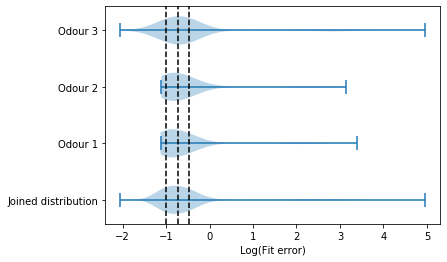

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_error_distributions(ax, combined_scores, yticklabels=['Joined distribution', 'Odour 1', 'Odour 2', 'Odour 3'], axvlines=fit_index_values[1:-1])

In [12]:
def plot_fits(fig, gs, true_vals, pred_vals, chosen_indexes, hor=True, legend_ax_index=2):
    if hor:
        subgs = gs.subgridspec(ncols=len(chosen_indexes), nrows=1)
    else:
        subgs = gs.subgridspec(ncols=1, nrows=len(chosen_indexes))
    axs = []
    for ax_i, index in enumerate(chosen_indexes):
        if ax_i != 0:
            
            ax = fig.add_subplot(subgs[ax_i], sharey=axs[-1])
            plt.setp(ax.get_yticklabels(), visible=False)
        else:
            ax = fig.add_subplot(subgs[ax_i])
        ax = plot_fit(ax, true_vals[index], label='True')
        ax = plot_fit(ax, pred_vals[index], label='Prediction')
        axs.append(ax)
        ax.set_xticks(range(32))
        ax.set_xticklabels(glyphs, fontsize=8, rotation=90)
        if ax_i == legend_ax_index:
            ax.legend()
    
    return axs

def plot_fit(ax, vals, label=None):
    mins = np.mean(vals, axis=0) - np.min(vals, axis=0)
    maxs = np.max(vals, axis=0) - np.mean(vals, axis=0)
    
    ax.errorbar(range(32), np.mean(vals, axis=0), yerr=(mins, maxs), fmt='o', label=label, markersize=3, linewidth=1)
    return ax

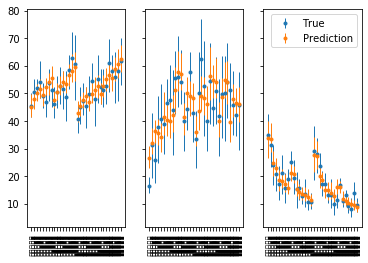

In [13]:
fig = plt.figure()
gs = GridSpec(1, 1)
plot_fits(fig, gs[0], all_test_true, all_test_preds, fit_indexes[1:-1])

In [14]:
combined_trial_scores = np.concatenate([[np.mean(i.test_scores, axis=0) for i in models] for models in [full_models1, full_models2, full_models3]])

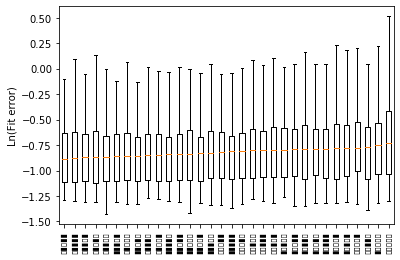

In [15]:
def plot_trial_scores(ax, trial_scores, sort_by_median=True):
    if sort_by_median:
        sorted_index = np.argsort(np.median(np.log10(trial_scores), axis=0))
        sorted_scores = np.log10(trial_scores)[:, sorted_index]
    else:
        sorted_scores = np.log10(trial_scores)
        sorted_index = range(32)
    ax.boxplot(sorted_scores, showfliers=False)
    ax.set_xticks(range(1, 33))
    ax.set_xticklabels(np.array(glyphs)[sorted_index], rotation=90, fontsize=8)
    ax.set_ylabel('Ln(Fit error)')
fig = plt.figure()
ax = fig.add_subplot(111)
plot_trial_scores(ax, combined_trial_scores, sort_by_median=True)

#Change to a conc vs onset scatter plot

In [16]:
all_reses = np.load('../Fig2/221027_all_svm_outs.npy')
preds1 = np.array(all_reses)[0, :, 0].reshape(500, 32)
trues1 = np.array(all_reses)[0, :, 1].reshape(500, 32)
preds2 = np.array(all_reses)[1, :, 0].reshape(500, 32)
trues2 = np.array(all_reses)[1, :, 1].reshape(500, 32)
preds3 = np.array(all_reses)[2, :, 0].reshape(500, 32)
trues3 = np.array(all_reses)[2, :, 1].reshape(500, 32)
cm1 = confusion_matrix(np.concatenate(trues1), np.concatenate(preds1), normalize='true', labels=range(32))
cm2 = confusion_matrix(np.concatenate(trues2), np.concatenate(preds2), normalize='true', labels=range(32))
cm3 = confusion_matrix(np.concatenate(trues3), np.concatenate(preds3), normalize='true', labels=range(32))

In [17]:
def plot_loglog_error(ax, scores_conc, scores_onset, lims='equal', label=None):
    ax.loglog(scores_conc, scores_onset, '.', label=label)
#     ax.set_xlabel('Log concentration error (a.u.)')
#     ax.set_ylabel('Log onset error (a.u.)')
    if lims == 'equal':
        max_lim = np.max([ax.get_ylim(), ax.get_xlim()])
        min_lim = np.min([ax.get_ylim(), ax.get_xlim()])
        ax.set_ylim(min_lim, max_lim)
        ax.set_xlim(min_lim, max_lim)
def plot_two_errors(fig, gs, all_scores1, all_scores2, all_scores3, all_scores4, lims='equal', label=None, orientation='h'):
    if orientation == 'h':
        sub_gs = gs.subgridspec(ncols=2, nrows=1, wspace=0.5)
    elif orientation == 'v':
        sub_gs = gs.subgridspec(ncols=1, nrows=2, wspace=0.5)
    error_ax1 = fig.add_subplot(sub_gs[0], aspect=1)
    error_ax2 = fig.add_subplot(sub_gs[1], aspect=1)
    for i in range(len(all_scores_conc)):
        plot_loglog_error(error_ax1, all_scores1[i], all_scores2[i], label=f'Odour {i+1}')
        plot_loglog_error(error_ax2, all_scores3[i], all_scores4[i])
    max_lim = np.max([error_ax1.get_ylim(), error_ax2.get_xlim()])
    min_lim = np.min([error_ax1.get_ylim(), error_ax2.get_xlim()])
    error_ax1.set_ylim(min_lim, max_lim)
    error_ax1.set_xlim(min_lim, max_lim)
    error_ax2.set_ylim(min_lim, max_lim)
    error_ax2.set_xlim(min_lim, max_lim)
    return error_ax1, error_ax2

In [18]:
test_scores_conc1 = [np.mean(i.test_scores) for i in conc_models1]
test_scores_conc2 = [np.mean(i.test_scores) for i in conc_models2]
test_scores_conc3 = [np.mean(i.test_scores) for i in conc_models3]

test_scores_cao1 = [np.mean(i.test_scores) for i in cao_models1]
test_scores_cao2 = [np.mean(i.test_scores) for i in cao_models2]
test_scores_cao3 = [np.mean(i.test_scores) for i in cao_models3]

test_scores_onset1 = [np.mean(i.test_scores) for i in onset_models1]
test_scores_onset2 = [np.mean(i.test_scores) for i in onset_models2]
test_scores_onset3 = [np.mean(i.test_scores) for i in onset_models3]

test_scores1 = [np.mean(i.test_scores) for i in full_models1]
test_scores2 = [np.mean(i.test_scores) for i in full_models2]
test_scores3 = [np.mean(i.test_scores) for i in full_models3]

all_scores_conc = [test_scores_conc1, test_scores_conc2, test_scores_conc3]
all_scores_onset = [test_scores_onset1, test_scores_onset2, test_scores_onset3]
all_scores_cao = [test_scores_cao1, test_scores_cao2, test_scores_cao3]
all_scores_full = [test_scores1, test_scores2, test_scores3]


Text(0, 0.5, 'Log temporal bin error (a.u.)')

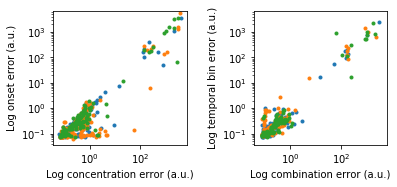

In [19]:
fig = plt.figure()
gs = GridSpec(1, 1)
ea1, ea2 = plot_two_errors(fig, gs[0], all_scores_conc, all_scores_onset, all_scores_cao, all_scores_full, orientation='h')
ea1.set_xlabel('Log concentration error (a.u.)')
ea1.set_ylabel('Log onset error (a.u.)')
ea2.set_xlabel('Log combination error (a.u.)')
ea2.set_ylabel('Log temporal bin error (a.u.)')

In [20]:
def plot_pred_odour(fig, gs, true_vals, pred_vals, chosen_indexes, legend_ax_index=2):

    subgs = gs.subgridspec(ncols=len(chosen_indexes), nrows=1)
    axs = []
    for ax_i, index in enumerate(chosen_indexes):
        if ax_i != 0:
            
            ax = fig.add_subplot(subgs[ax_i], sharey=axs[-1])
            plt.setp(ax.get_yticklabels(), visible=False)
        else:
            ax = fig.add_subplot(subgs[ax_i])
        ax.scatter(range(32), true_vals[index], label='True')
        ax.scatter(range(32), pred_vals[index], label='Prediction')
        axs.append(ax)
        ax.set_xticks(range(32))
        ax.set_xticklabels(glyphs, fontsize=8, rotation=90)
        if ax_i == legend_ax_index:
            ax.legend()
    
    return axs

def pred_other_odour(model1, model2, model3, unit_usrt, ui, pred_trial = -1, ratio_schema = 'pred_trial', include_t=False):
    full_array = em.trial_arrays['diff_array']
    if ratio_schema == 'pred_trial':
        ratio_w1 = model1.true_resp[-1]/((model1.true_resp[-1]+model2.true_resp[-1]))
        ratio_w2 = model2.true_resp[-1]/((model1.true_resp[-1]+model2.true_resp[-1]))
    elif ratio_schema == 'mean':
        ratio_w1 = np.mean(model1.true_resp)/((np.mean(model1.true_resp)+np.mean(model2.true_resp)))
        ratio_w2 = np.mean(model2.true_resp)/((np.mean(model1.true_resp)+np.mean(model2.true_resp)))
    elif ratio_schema == 'max':
        if model1.true_resp[-1] > model2.true_resp[-1]:
            ratio_w1 = 1
            ratio_w2 = 0
        else:
            ratio_w1 = 0
            ratio_w2 = 1
    if not include_t:
        pred_ws = model1.opt_out.x[:-1]*ratio_w1 + model2.opt_out.x[:-1]*ratio_w2
        avg_thresh = (model1.opt_out.x[-1] + model2.opt_out.x[-1])/2
        pred_out = pred_ws @ full_array[pred_trial]
        scale = (np.log(model3.true_resp[pred_trial]) - avg_thresh)/pred_out
        pred_ws = scale*pred_ws
        pred_ws = list(pred_ws) + [avg_thresh]
    else:
        pred_ws = model1.opt_out.x*ratio_w1 + model2.opt_out.x*ratio_w2
        full_array_1 = np.append(full_array, np.ones((32, 1)), axis=1)
        pred_out = pred_ws @ full_array_1[pred_trial]
        scale = (np.log(model3.true_resp[pred_trial]))/pred_out
        pred_ws = scale*pred_ws
    model_test = em.ExponentialCustomTrialArray(unit_usrt, ui, full_array)
    model_test.fit(W=pred_ws)
    return model_test

In [21]:
pred_scores1 = []
pred_scores2 = []
pred_scores3 = []

pred_models1 = []
pred_models2 = []
pred_models3 = []
for ui in tqdm(good_indexes, position=0, leave=False):
    model_test = pred_other_odour(full_models2[ui], full_models3[ui], full_models1[ui], unit_usrt1, ui, include_t=True)
    pred_scores1.append(model_test.fit_score)
    pred_models1.append(model_test)
    model_test = pred_other_odour(full_models1[ui], full_models3[ui], full_models2[ui], unit_usrt2, ui, include_t=True)
    pred_scores2.append(model_test.fit_score)
    pred_models2.append(model_test)
    model_test = pred_other_odour(full_models2[ui], full_models1[ui], full_models3[ui], unit_usrt3, ui, include_t=True)
    pred_scores3.append(model_test.fit_score)
    pred_models3.append(model_test)
    

pred_models_pred1 = [i.pred_resp for i in pred_models1]
pred_models_pred2 = [i.pred_resp for i in pred_models2]
pred_models_pred3 = [i.pred_resp for i in pred_models3]

pred_models_true1 = [i.true_resp for i in pred_models1]
pred_models_true2 = [i.true_resp for i in pred_models2]
pred_models_true3 = [i.true_resp for i in pred_models3]

all_pred_models_pred = np.concatenate([pred_models_pred1, pred_models_pred2, pred_models_pred3])
all_pred_models_true = np.concatenate([pred_models_true1, pred_models_true2, pred_models_true3])

NameError: name 'fit_indexes_pred_odour' is not defined

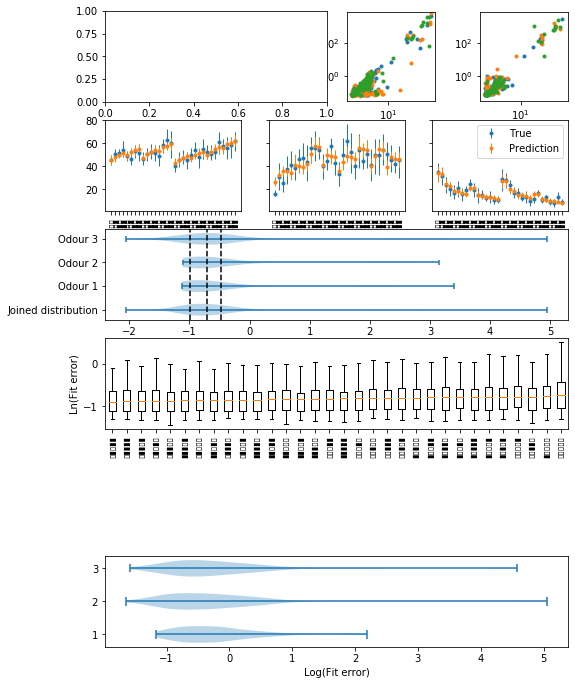

In [22]:
fig = plt.figure(figsize=(8.3, 11.7))
gs = GridSpec(6, 4)
ea1, ea2 = plot_two_errors(fig, gs[0, 2:], all_scores_conc, all_scores_onset, all_scores_cao, all_scores_full, orientation='h')
diagram_ax = fig.add_subplot(gs[0, :-2])
plot_axes = plot_fits(fig, gs[1, :], all_test_true, all_test_preds, fit_indexes[1:-1])
dist_ax = fig.add_subplot(gs[2, :])
plot_error_distributions(dist_ax, combined_scores, yticklabels=['Joined distribution', 'Odour 1', 'Odour 2', 'Odour 3'], axvlines=fit_index_values[1:-1])
trial_error_ax = fig.add_subplot(gs[3, :])
plot_trial_scores(trial_error_ax, combined_trial_scores)
other_odour_pred_ax = fig.add_subplot(gs[5, :])
plot_error_distributions(other_odour_pred_ax, [pred_scores1, pred_scores2, pred_scores3])
#pred_odour_ax = fig.add_subplot(gs[4, :])
plot_pred_odour(fig, gs[4, :], all_pred_models_true, all_pred_models_pred, fit_indexes_pred_odour[1:-1])
# heatmap_ax = fig.add_subplot(gs[1, :])
# vmax = np.max(np.abs(firing_difference1))
# link = linkage(np.array(firing_difference1), method='complete', optimal_ordering=True)
# dend = dendrogram(link, no_plot=True)
# im = heatmap_ax.imshow(np.array(firing_difference1)[dend['leaves']].T, cmap='bwr', vmax=vmax, vmin=-vmax)
# divider = make_axes_locatable(heatmap_ax)
# cax = divider.append_axes("right", size='2%', pad=0.05)
# plt.colorbar(im, cax=cax)
#plt.colorbar()

In [26]:
## pred odour further work
full_responding_units = []
for i in good_indexes:
    model1 = full_models1[i]
    model2 = full_models2[i]
    model3 = full_models3[i]
    
    odour1_resp_diff = abs(model1.true_resp[0] - model1.true_resp[-1])
    odour2_resp_diff = abs(model2.true_resp[0] - model2.true_resp[-1])
    odour3_resp_diff = abs(model3.true_resp[0] - model3.true_resp[-1])
    
    odour1_var = np.sqrt(model1.unit_sr_var[0])
    odour2_var = np.sqrt(model2.unit_sr_var[0])
    odour3_var = np.sqrt(model3.unit_sr_var[0])
    if i == 41:
        print(odour1_resp_diff, odour1_var)
    if odour1_resp_diff > odour1_var and odour2_resp_diff > odour2_var and odour3_resp_diff > odour3_var:
        full_responding_units.append(i)

16.26666666666667 4.935134806219133


In [29]:
print(full_responding_units)

[23, 26, 36, 38, 40, 41, 58, 61, 65, 70, 86, 88, 89, 93, 94, 95, 98, 99, 101, 102, 106, 108, 109, 110, 111, 113, 114, 117, 118, 119, 120, 124, 127, 129, 130, 132, 133, 134, 135, 136, 138, 140, 141, 143]


In [32]:
def pred_and_plot_other_odour(fig, gs, model1, model2, model3, unit_usrt, ui):
    pred_model = pred_other_odour(model1, model2, model3, unit_usrt, ui)
    sub_gs = gs.subgridspec(1, 3)
    ax1 = fig.add_subplot(sub_gs[0])
    ax2 = fig.add_subplot(sub_gs[1])
    ax3 = fig.add_subpl
    
    ax1.plot(model1.true_resp)
    ax1.plot()

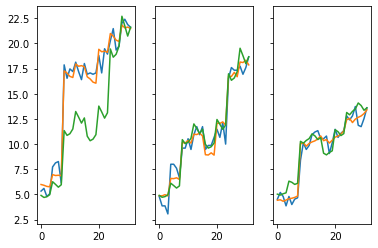

In [63]:
fig, ax = plt.subplots(1, 3, sharey=True)
ui=41
pred_model1 = pred_other_odour(full_models3[ui], full_models2[ui], full_models1[ui], unit_usrt1, ui)
pred_model2 = pred_other_odour(full_models3[ui], full_models2[ui], full_models2[ui], unit_usrt2, ui)
pred_model3 = pred_other_odour(full_models1[ui], full_models2[ui], full_models3[ui], unit_usrt3, ui)
full_models1[ui].fit()
full_models2[ui].fit()
full_models3[ui].fit()

ax[0].plot(pred_model1.true_resp)
ax[0].plot(full_models1[ui].pred_resp)
ax[0].plot(pred_model1.pred_resp)

ax[1].plot(pred_model2.true_resp)
ax[1].plot(full_models2[ui].pred_resp)
ax[1].plot(pred_model2.pred_resp)

ax[2].plot(pred_model3.true_resp)
ax[2].plot(full_models3[ui].pred_resp)
ax[2].plot(pred_model3.pred_resp)